# Predicting Recessions
## Business Cylces
- Economies go through expansions and recessions
- Expansion
    - Periods of growth in GDP
- Recessions
    - Periods of GDP decline
    - Recessions are generally defined as two quarters of decline in GDP
- We saw earlier how yield curves historically have inverted before recessions
- Now let us try to use more predictors to see if we can predict recessions

- Why should we do this?
    - Predicting Recessions better than the stock market will be very profitable for investors
    - Policy makers can take appropriate action

- In last lecture we saw machine learning is essentially figuring out the f in 
$$ Y = f(X) + e $$
- In our task what is Y?
- Is that a quantitative or qualitative variable?
- Is this a regression or classification problem?

- What predictors can we use (X)?
- Yield curve
    - Spread between 10 year treasury yield and 2 year treasury yield
- Unemployment rate
- Change in Inventory
- New Housing Permits
- Percentage change in housing prices
- Percentage change in retail sales
- Data source: FRED

In [1]:
# Import Datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import time
# Direct data access from yahoo
import pandas_datareader.data as web

- Symbols for getting the data from FRED
- 10 and 2 year spread - T10Y2Y
- Unemployment rate - UNRATE
- Change in Inventory - CBIC1
- New Housing Permits - PERMIT
- Housing prices - USSTHPI
- Retail sales - SLRTTO01USQ661S
    - For housing prices and retail sales need to compute percentage change in retail sales

In [2]:
# Extract Predictors 
Predictors=web.DataReader(["T10Y2Y", "UNRATE", "CBIC1", "PERMIT","USSTHPI", "SLRTTO01USQ661S"], "fred", "1976-01-01", "2018-12-31")
Predictors

,T10Y2Y,UNRATE,CBIC1,PERMIT,USSTHPI,SLRTTO01USQ661S
DATE,,,,,,
1976-01-01,NaN,7.9,40.608,1195.0,62.90,52.835884
1976-02-01,NaN,7.7,NaN,1190.0,NaN,NaN
1976-03-01,NaN,7.6,NaN,1164.0,NaN,NaN
1976-04-01,NaN,7.7,61.087,1132.0,65.45,53.606131
1976-05-01,NaN,7.4,NaN,1194.0,NaN,NaN
...,...,...,...,...,...,...
2018-12-25,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-26,0.20,NaN,NaN,NaN,NaN,NaN
2018-12-27,0.21,NaN,NaN,NaN,NaN,NaN


In [3]:
# Take mean of the predictors every quarter
Predictors_1=Predictors.resample('QS').mean()
Predictors_1.columns=["YIELD","UNRATE","C_INV", "PERMIT","HOUSE","RETAIL"]

In [4]:
# Need annual precentage change in house prices and retail sales 
Predictors_1["C_HOUSE"]=Predictors_1["HOUSE"]/Predictors_1["HOUSE"].shift(4)-1
Predictors_1["C_RETIAL"]=Predictors_1["RETAIL"]/Predictors_1["RETAIL"].shift(4)-1

In [5]:
#Drop house and retail
Predictors_2=Predictors_1.drop(["HOUSE","RETAIL"],axis=1).dropna()
Predictors_2

,YIELD,UNRATE,C_INV,PERMIT,C_HOUSE,C_RETIAL
DATE,,,,,,
1977-01-01,1.332222,7.500000,34.343,1562.000000,0.103816,0.037939
1977-04-01,1.248254,7.133333,51.245,1693.333333,0.110466,0.032931
1977-07-01,0.814762,6.900000,89.947,1713.666667,0.117302,0.034861
1977-10-01,0.454833,6.666667,47.311,1761.000000,0.147334,0.038371
1978-01-01,0.466393,6.333333,56.354,1758.333333,0.146190,0.016099
...,...,...,...,...,...,...
2017-04-01,0.963333,4.366667,0.637,1263.333333,0.060459,0.022948
2017-07-01,0.878730,4.300000,56.087,1277.000000,0.058800,0.024696
2017-10-01,0.677097,4.133333,25.302,1316.666667,0.059259,0.037249


In [6]:
# Get Recession dates
Recession=web.DataReader(["USRECQ"],"fred","1977-01-01","2018-04-30")
Recession

,USRECQ
DATE,
1977-01-01,0
1977-04-01,0
1977-07-01,0
1977-10-01,0
1978-01-01,0
...,...
2017-04-01,0
2017-07-01,0
2017-10-01,0


In [7]:
Recession[Recession["USRECQ"]==1]

,USRECQ
DATE,
1980-04-01,1
1980-07-01,1
1981-10-01,1
1982-01-01,1
1982-04-01,1
1982-07-01,1
1982-10-01,1
1990-10-01,1
1991-01-01,1


In [8]:
Recession["Change"]=Recession["USRECQ"].diff()
Recession[Recession["Change"]==-1]

,USRECQ,Change
DATE,,
1980-10-01,0,-1.0
1983-01-01,0,-1.0
1991-04-01,0,-1.0
2002-01-01,0,-1.0
2009-07-01,0,-1.0


In [9]:
# Start Date of recession
Start_Dates=Recession[Recession["Change"]>0].index
End_Dates=Recession[Recession["Change"]<0].index+pd.offsets.QuarterEnd(-1)
Rec_Dates=pd.DataFrame([Start_Dates,End_Dates]).transpose()
Rec_Dates.columns=(["Start","End"])

In [10]:
Rec_Dates

,Start,End
0,1980-04-01,1980-09-30
1,1981-10-01,1982-12-31
2,1990-10-01,1991-03-31
3,2001-04-01,2001-12-31
4,2008-01-01,2009-06-30


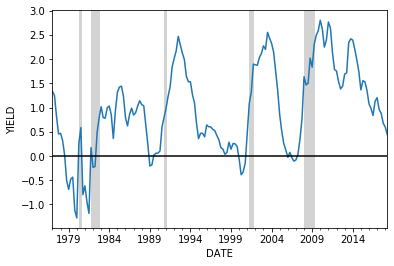

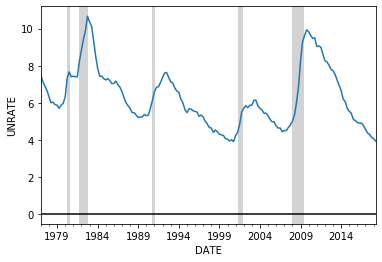

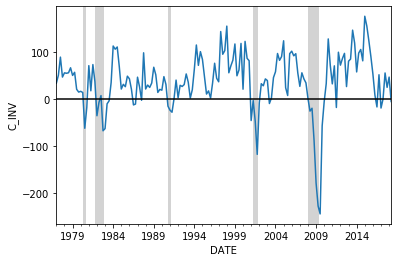

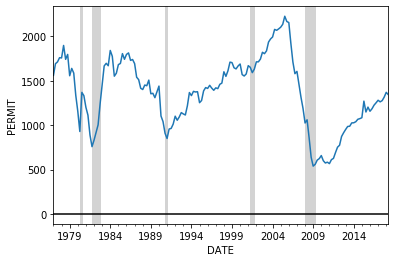

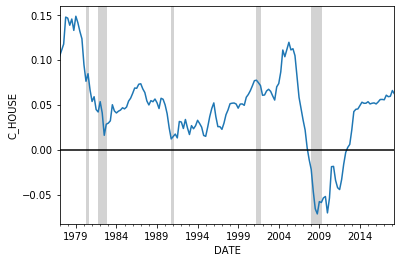

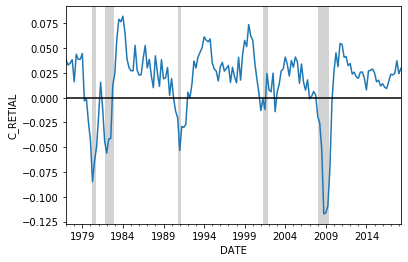

In [11]:
for j in Predictors_2.columns: 
    Predictors_2[j].plot()
# Recession lines
    for i in range(len(Rec_Dates)): 
        plt.axvspan(Rec_Dates.loc[i,"Start"],Rec_Dates.loc[i,"End"], color='lightgrey')
    plt.axhline(y=0,color='k')
    plt.ylabel(j)
    plt.show()

- We want to see whether the data from one quarter
    - can predict the recession in the next quarter
- We are interested in 
$$ Y_{t+1}=f(X_{t})+e_{t+1}$$
- where t represents the quarters
- We can do that either by lagging the predictors by one quarter

In [12]:
X=Predictors_2.shift(1).dropna()
y=Recession["USRECQ"]
y=y[y.index>"1977-01-01"]
X,y

(               YIELD    UNRATE   C_INV       PERMIT   C_HOUSE  C_RETIAL
 DATE                                                                   
 1977-04-01  1.332222  7.500000  34.343  1562.000000  0.103816  0.037939
 1977-07-01  1.248254  7.133333  51.245  1693.333333  0.110466  0.032931
 1977-10-01  0.814762  6.900000  89.947  1713.666667  0.117302  0.034861
 1978-01-01  0.454833  6.666667  47.311  1761.000000  0.147334  0.038371
 1978-04-01  0.466393  6.333333  56.354  1758.333333  0.146190  0.016099
 ...              ...       ...     ...          ...       ...       ...
 2017-04-01  1.202258  4.566667 -18.876  1281.333333  0.055365  0.023672
 2017-07-01  0.963333  4.366667   0.637  1263.333333  0.060459  0.022948
 2017-10-01  0.878730  4.300000  56.087  1277.000000  0.058800  0.024696
 2018-01-01  0.677097  4.133333  25.302  1316.666667  0.059259  0.037249
 2018-04-01  0.598033  4.066667  47.267  1370.666667  0.065667  0.024168
 
 [165 rows x 6 columns], DATE
 1977-04-01    0
 1

- What is the unconditional probability of recession?

In [13]:
np.mean(y)

0.10909090909090909

In [14]:
# Split the data into testing and training datasets 
from sklearn.model_selection import train_test_split
# Splitting 25% as test and 75% as training
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20)

In [15]:
# Let us try linear regression
from sklearn.linear_model import LinearRegression

model=LinearRegression()

# Fit the model
model.fit(X_train,y_train)

# Model Prediction
pred=model.predict(X_train).round(2)
pred

array([ 0.09,  0.42, -0.06,  0.2 ,  0.06,  0.51, -0.02,  0.13, -0.03,
       -0.  , -0.06,  0.01, -0.03,  0.52,  0.08,  0.1 ,  0.39,  0.27,
        0.57, -0.04, -0.07,  0.23, -0.09,  0.05,  0.15,  0.02,  0.08,
       -0.09,  0.07,  0.09,  0.13,  0.09, -0.04,  0.02,  0.14, -0.14,
       -0.07,  0.16,  0.18, -0.06,  0.06,  0.05,  0.14, -0.18, -0.11,
        0.12,  0.  ,  0.39,  0.08,  0.26, -0.11,  0.1 ,  0.1 ,  0.14,
        0.15, -0.04,  0.07, -0.11,  0.03, -0.12,  0.15,  0.25,  0.5 ,
        0.1 , -0.13, -0.1 , -0.08, -0.07, -0.01,  0.63,  0.47, -0.11,
       -0.1 ,  0.03,  0.48, -0.14, -0.05, -0.1 ,  0.04, -0.08, -0.01,
        0.54,  0.03,  0.04,  0.19,  0.24, -0.05, -0.08,  0.04, -0.17,
       -0.03,  0.57, -0.01,  0.07,  0.1 ,  0.18,  0.11, -0.  ,  0.03,
       -0.04,  0.09, -0.06,  0.34,  0.17, -0.08, -0.07, -0.04,  0.04,
        0.07,  0.03, -0.12,  0.02,  0.41,  0.03, -0.09,  0.04,  0.4 ,
       -0.01,  0.26,  0.44,  0.11,  0.09,  0.04,  0.03,  0.  ,  0.  ,
        0.07,  0.16,

- In the data recession was coded as 1 and expansion as 0
- How do we interpret these predictions above?
- A simple way is to consider all values above 0.5 as recessions

In [16]:
pred_1=np.array([int(i>0.5) for i in pred])
pred_1

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [17]:
# How many of the classifications were correct 
np.mean(pred_1==y_train)

0.946969696969697

In [18]:
# Let us check the performance in testing data
pred=model.predict(X_test)
pred_1=np.array([int(i>0.5) for i in pred])
np.mean(pred_1==y_test)

0.8181818181818182

In [19]:
# Logsistic regression
from sklearn.linear_model import LogisticRegression

model=LogisticRegression()

# Fit the model
model.fit(X_train,y_train)

# Model Prediction
model.predict(X_train)

C:\Users\badrinath\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int64)

In [20]:
# Training dataset Performance
model.score(X_train,y_train)

0.946969696969697

In [21]:
# Testing dataset Performance
model.score(X_test,y_test)

0.7878787878787878

Text(0, 0.5, 'C_RETIAL')

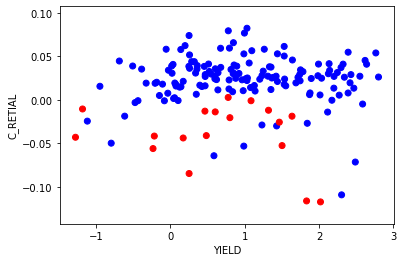

In [22]:
c=np.array(["k"]*len(y))
for i in range(len(y)):
    if y[i]==1:
        c[i]="r"
    else:
        c[i]="b"
plt.scatter(X["YIELD"],X["C_RETIAL"],color=c)
plt.xlabel("YIELD")
plt.ylabel("C_RETIAL")

# k Nearest Neighbors

In [24]:
#import k Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier

#Set the number of neighbors
model=KNeighborsClassifier(n_neighbors=1)

# fit the model
model.fit(X_train,y_train)

#Predictions
model.predict(X_train)

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int64)

In [25]:
# Training Performance
model.score(X_train,y_train)

1.0

In [26]:
# Testing performance
model.score(X_test,y_test)

0.8181818181818182

# Support Vector Machines (SVM)

In [27]:
#SVM
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

#Set the number of neighbors
model=Pipeline((
    ("scaler",StandardScaler()),
    ("linear_svc",LinearSVC(C=1,loss="hinge")),
))

# fit the model
model.fit(X_train,y_train)

#Predictions
model.predict(X_train)

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int64)

In [28]:
# Training data performance
model.score(X_train,y_train)

0.9621212121212122

In [29]:
# Testing data performance
model.score(X_test,y_test)

0.8181818181818182

# Task

Tryout different kNearest Neighbors (by changing no of neighbors) and SVM (by changing C)
1. Does the training score improve?
2. Does the testing score improve?